In [ ]:
!pip install request

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torchvision
import torch
import torch.nn as nn
from torch.utils.data import DataLoader

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
!unzip /content/drive/MyDrive/Diplom/first_images.zip

In [ ]:
# Скачаем данные, собранные с Циана из Москвы и Санкт Петербурга
df_Moscow = pd.read_csv('/content/drive/MyDrive/Diplom/Moscow-data.csv')
df_SP = pd.read_csv('/content/drive/MyDrive/Diplom/SP-data.csv')

In [ ]:
print(df_Moscow.shape, df_SP.shape)

(5793, 17) (5572, 17)


In [ ]:
# Объединим эти таблицы
df_new = pd.concat([df_Moscow, df_SP]).reset_index()
df_new = df_new.drop(columns = ['index', 'Unnamed: 0'])

torch.Size([3, 444, 640])


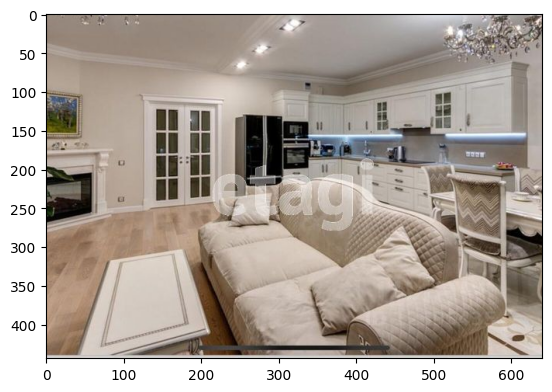

In [ ]:
# Посмотрим, как выглядят наши картинки
import matplotlib.pyplot as plt
img = torchvision.io.read_image('first_images/moscow_image_0002983.jpg') / 255
print(img.shape)
plt.imshow(img.permute(1, 2, 0), cmap='gray')

In [ ]:
len(df_new)

11365

In [ ]:
df_new = df_new.fillna('')
df_new = df_new.drop(df_new[df_new['Repair_types_id'] == ''].index).reset_index().drop(columns=['index'])

In [ ]:
# Приведем наш таргет к типу int
df_new['Repair_types_id'] = df_new['Repair_types_id'].apply(int)
df_Moscow['Repair_types_id'] = df_Moscow['Repair_types_id'].apply(int)

In [ ]:
# Удалим все картинки, чей размер меньше 240*240, чтобы потом можно было сделать T.RandomCrop(240)
drop_list = []
for i in range(len(df_new)):
    try:
        img = torchvision.io.read_image(df_new.iloc[i]['im_dir']) / 255
        if img.shape[1] < 240 or img.shape[2] < 240:
            drop_list += [i]
            print(img.shape)
    except:
        drop_list += [i]

torch.Size([3, 218, 421])
torch.Size([3, 408, 230])
torch.Size([3, 207, 274])


In [ ]:
len(drop_list)

134

In [ ]:
df_new = df_new.drop(drop_list)

In [ ]:
# Создадим класс, который будет возвращать считанную картинку
class MyDataset(torch.utils.data.Dataset):
    def __init__(self, X, y=None, transform=None):
        self.transform = transform
        self.num_elem = len(X)
        self.X = X
        self.target = y

    def __getitem__(self, idx):
        image = torchvision.io.read_image(self.X.iloc[idx]) / 255

        if (self.transform is not None):
            image = self.transform(image)
        if (self.target is not None):
            return image, self.target.iloc[idx]
        return image
    
    def __len__(self):
        return self.num_elem

In [ ]:
# Зададим аугументации, которые подходят для модели EfficientNet
import torchvision.transforms as T

train_transform = nn.Sequential(
    T.RandomCrop(240),
    T.ColorJitter(brightness=.1),
    # T.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 1)),
    T.Resize(256),
    T.Normalize(mean=[0.485, 0.456, 0.406], 
                         std=[0.229, 0.224, 0.225])
)

test_transform = nn.Sequential(
    T.CenterCrop(240),
    T.Resize(256),
    T.Normalize(mean=[0.485, 0.456, 0.406], 
                         std=[0.229, 0.224, 0.225])
)

In [ ]:
train_dataset = MyDataset(df_new['im_dir'], df_new['Repair_types_id'], transform=train_transform)

In [ ]:
drop_list = []
for i in range(len(train_dataset)):
    try:
        train_dataset[i][0]
    except:
        drop_list += [i]

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


In [ ]:
len(drop_list)

0

In [ ]:
df_new = df_new.drop(drop_list)

In [ ]:
# Разделим наш датасет на обучающую и тестовую выборку
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df_new['im_dir'], df_new['Repair_types_id'], test_size=0.15, random_state=42, stratify = df_new['Repair_types_id'])

In [ ]:
# from torchvision.models import efficientnet_b1, EfficientNet_B1_Weights
# transforms = EfficientNet_B1_Weights.IMAGENET1K_V1.transforms()
# transforms

In [ ]:
train_dataset = MyDataset(X_train, y_train, transform=train_transform)
test_dataset = MyDataset(X_test, y_test, transform=test_transform)

batch_size=32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

torch.Size([3, 256, 256])


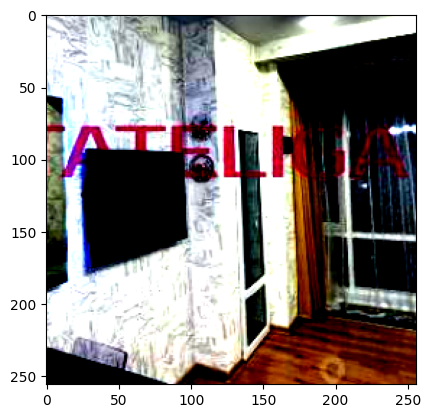

In [ ]:
# Посмотрим как выглядят наши фотографии после применения аугументаций
img = train_dataset[7][0]
print(img.shape)
plt.imshow(img.permute(1, 2, 0), cmap='gray')

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

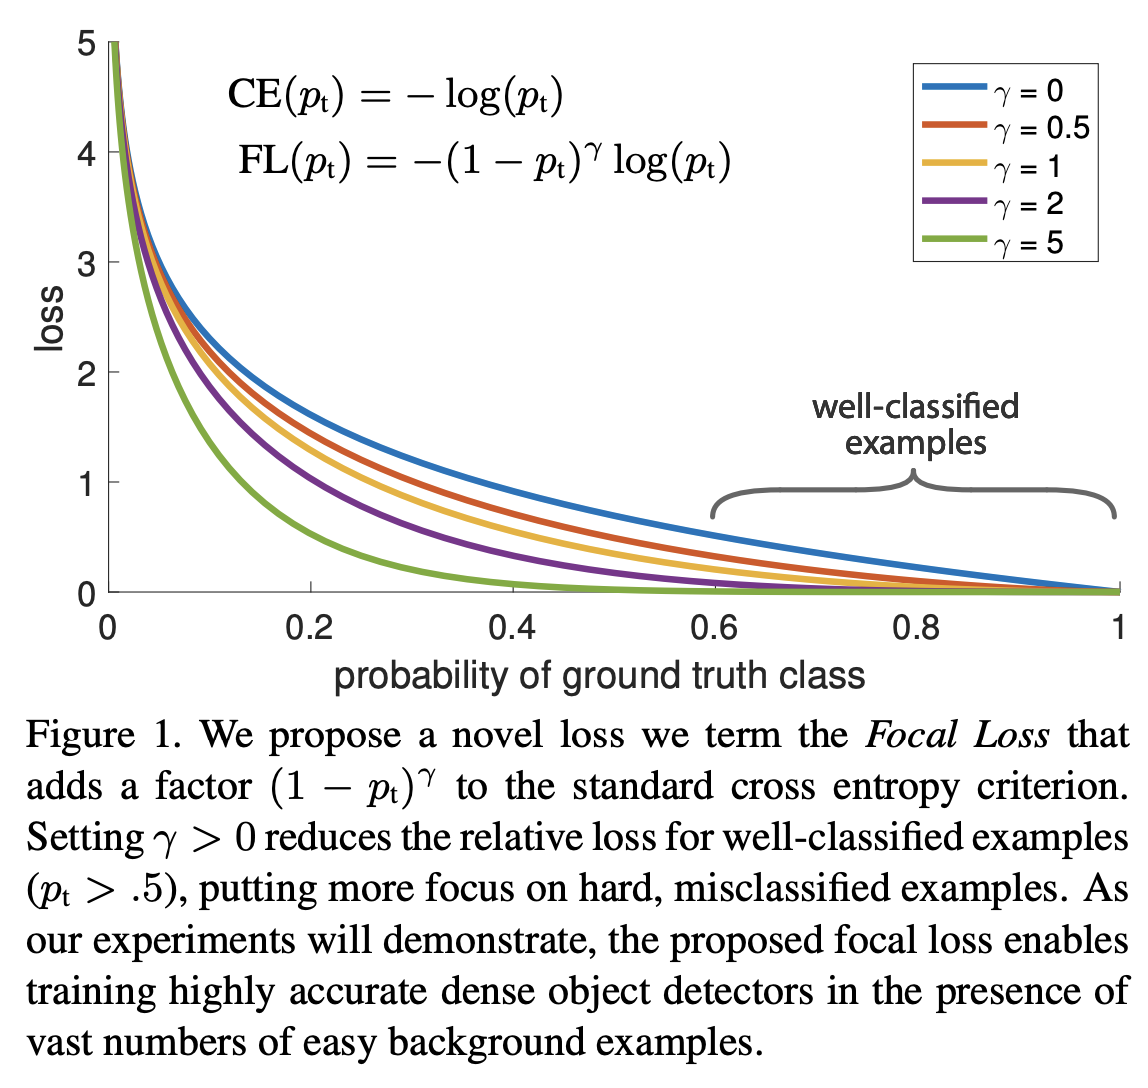

In [ ]:
# Создадим класс, который будет нам считать Focal loss
class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2, logits=False, reduce=True):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.logits = logits
        self.reduce = reduce

    def forward(self, inputs, targets):
    
        BCE_loss = nn.CrossEntropyLoss()(inputs, targets)

        pt = torch.exp(-BCE_loss)
        F_loss = self.alpha * (1-pt)**self.gamma * BCE_loss

        if self.reduce:
            return torch.mean(F_loss)
        else:
            return F_loss

In [ ]:
from tqdm.notebook import tqdm
# from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from IPython.display import clear_output

def train_epoch(model, optimizer):
    loss_log, roc_auc_log = [], []
    model.train()
    i = 0
    for x_batch, y_batch in tqdm(train_loader):
#         if i > 10:
#             break
#         print(i)
        data = x_batch.to(device)
        target = y_batch.to(device)

        optimizer.zero_grad()
        output = model(data)
        roc_auc = 0
        with torch.no_grad():
            try:
                roc_auc = roc_auc_score(y_batch.cpu().detach().numpy(), nn.functional.softmax(output, -1).cpu().detach().numpy(), multi_class='ovr')
            except:
                pass
            roc_auc_log.append(roc_auc)

        loss = FocalLoss()(output, target)
        loss.backward()
        optimizer.step()
        loss = loss.item()
        loss_log.append(loss)
        i += 1
    return loss_log, roc_auc_log

def test(model):
    loss_log, roc_auc_log = [], []
    model.eval()
    i = 0
    for x_batch, y_batch in tqdm(test_loader):
#         if i > 10:
#             break
#         print(i)
        data = x_batch.to(device)
        target = y_batch.to(device)

        output = model(data)
        loss = FocalLoss()(output, target)
        roc_auc = 0
        with torch.no_grad():
            try:
                roc_auc = roc_auc_score(y_batch.cpu().detach().numpy(), nn.functional.softmax(output, -1).cpu().detach().numpy(), multi_class='ovr')
            except:
                pass
            roc_auc_log.append(roc_auc)
        
        loss = loss.item()
        loss_log.append(loss)
        i += 1
    return loss_log, roc_auc_log

def plot_history(train_history, val_history, title='loss'):
    plt.figure()
    plt.title('{}'.format(title))
    plt.plot(train_history, label='train', zorder=1)
    
    points = np.array(val_history)
    
    plt.scatter(points[:, 0], points[:, 1], marker='+', s=180, c='orange', label='val', zorder=2)
    plt.xlabel('train steps')
    
    plt.legend(loc='best')
    plt.grid()

    plt.show()
    
def train(model, opt, n_epochs):
    hist = []
    model.to(device)
    train_log, train_roc_auc_log = [], []
    val_log, val_roc_auc_log = [], []

    batchsize = 32

    for epoch in range(n_epochs):
        print("Epoch {} of {}".format(epoch, n_epochs))
        train_loss, train_roc_auc = train_epoch(model, opt)

        val_loss, val_roc_auc = test(model)

        train_log.extend(train_loss)
        train_roc_auc_log.extend(train_roc_auc)

        steps = len(X_train) / batchsize
        val_log.append((steps * (epoch + 1), np.mean(val_loss)))
        val_roc_auc_log.append((steps * (epoch + 1), np.mean(val_roc_auc)))

        clear_output()
        plot_history(train_log, val_log)    
        plot_history(train_roc_auc_log, val_roc_auc_log, title='roc_auc')
        print("Epoch {} roc_auc = {:.2%}".format(epoch, val_roc_auc_log[-1][1]))
        hist += [(epoch, val_roc_auc_log[-1][1])]
#         torch.save(model, './model_regnet_AdamW1' + str(epoch) + '.pth')
    
    for epoch, auc in hist:
        print(epoch, ': ', auc)
            
    print("Final roc_auc: {:.2%}".format(val_roc_auc_log[-1][1]))

In [ ]:
# !pip install --upgrade pip

In [ ]:
# Зададим нашу модель и заморозим первые несколько слоев
import torchvision
from torchvision.models import efficientnet_b1, EfficientNet_B1_Weights
import torch.nn as nn

def count_parameters(model):
    model_parameters = filter(lambda p: p.requires_grad, model.parameters())
    return sum([np.prod(p.size()) for p in model_parameters])

model = efficientnet_b1(weights=EfficientNet_B1_Weights.IMAGENET1K_V1)
model.classifier = nn.Sequential(
    nn.Dropout(p=0.2, inplace=True),
    nn.Linear(in_features=1280, out_features=4, bias=True)
)
print("Total number of trainable parameters:", count_parameters(model))
for name, param in model.named_parameters():
    if name == 'features.4.1.block.0.1.weight':
        break
    else:
        param.requires_grad = False
    # if name != 'classifier.1.weight' and name != 'classifier.1.bias':
    #     param.requires_grad = False
    # else:
    #     param.requires_grad = True

Total number of trainable parameters: 6518308


In [ ]:
model

In [ ]:
from collections import OrderedDict
# model.avgpool = nn.Sequential (
#     nn.AdaptiveAvgPool2d(output_size=1),
#     # nn.Linear(in_features=1280, out_features=250, bias=True)
# )

# model.classifier = nn.Sequential (
#     nn.Dropout(p=0.2, inplace=True),
#     nn.Linear(in_features=1280, out_features=256, bias=True),
#     nn.Linear(in_features=256, out_features=4, bias=True),
# )

model.classifier = nn.Sequential(OrderedDict([
          ('dropout', nn.Dropout(p=0.2, inplace=True)),
          ('linear1', nn.Linear(in_features=1280, out_features=256, bias=True)),
          ('linear2', nn.Linear(in_features=256, out_features=4, bias=True)),
        #   ('relu2', nn.ReLU())
        ]))

In [ ]:
import warnings
warnings.filterwarnings("ignore")

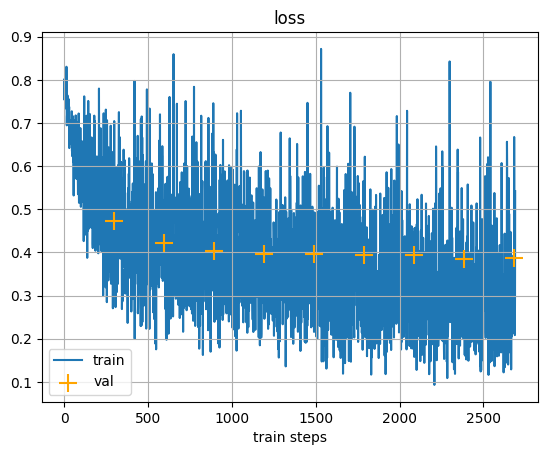

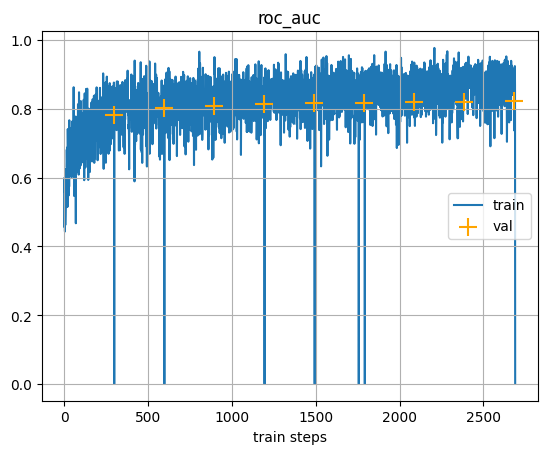

Epoch 8 roc_auc = 82.35%
0 :  0.7817339073683904
1 :  0.8011975707859715
2 :  0.8089711719828306
3 :  0.8138840864213811
4 :  0.8165320398552807
5 :  0.8154699636509541
6 :  0.8181747437921485
7 :  0.8209388454142662
8 :  0.8235423247838972
Final roc_auc: 82.35%


In [ ]:
# Обучим нашу модель
opt = torch.optim.AdamW(model.parameters(), lr=0.00005)
criterion = nn.CrossEntropyLoss()
train(model, opt, 9)

In [ ]:
# Сохраним нашу модель
torch.save(model, './eff_net_model_82')